## Libs

In [193]:
import pandas as pd 
import yfinance as yf 
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import talib
import bt

## Data and indicators 

In [194]:
data = yf.download('AAPL' , start = '2023-01-01',end ='2024-12-31' )
data.columns = data.columns.get_level_values(0) #because multindex , need 1D for candleStick


C:\Users\mayah\AppData\Local\Temp\ipykernel_13044\372835716.py:1: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


In [195]:
def plotLowAndHigh (data_frame) :
    
    plt.figure(figsize=(8,4))
    plt.plot(data_frame['Low'], color = 'red')
    plt.plot(data_frame['High'], color = 'green')
    plt.title('low and high ')
    plt.show()    

In [196]:
def plotCandles(data_frame):
    candlestick = go.Candlestick(
    x=data_frame.index,
    open=data_frame['Open'],
    high=data_frame['High'],
    low=data_frame['Low'],
    close=data_frame['Close'])
    fig = go.Figure(candlestick)
    fig.update_layout(title='prices')                        
    fig.show()



In [197]:
plotCandles(data)

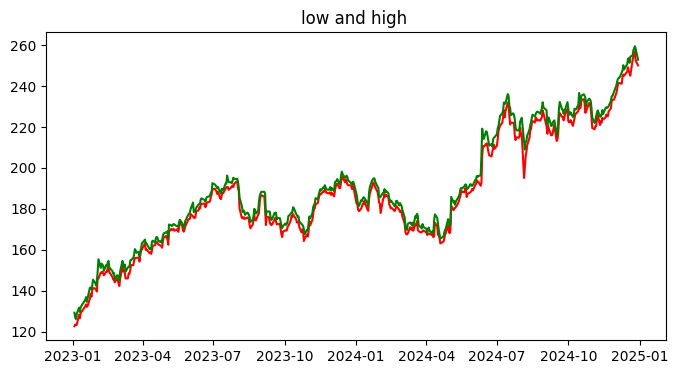

In [198]:
plotLowAndHigh(data )

In [199]:
#SWING TRADER (BY WEEK)
data_weekly = data.resample('W').mean()

In [200]:
#calculatin daily return 
data['daily_return'] = data['Close'].pct_change()*100

In [201]:
# Plot the histogram
def dailyHistogram(data_frame):
    data_frame['daily_return'].hist(bins=100, color='red')
    plt.ylabel('Frequency')
    plt.xlabel('Daily return')
    plt.title('Daily return histogram')
    plt.show()

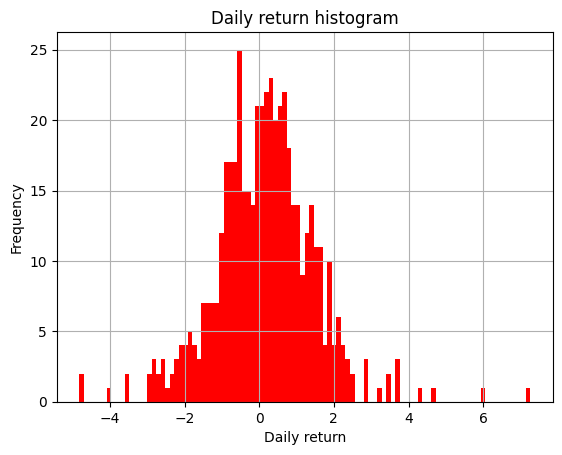

In [202]:
dailyHistogram(data)

In [203]:

def sma(data_frame , period ):
    data_frame[f"sma {period}"] = data_frame['Close'].rolling(window=period).mean()
    plt.plot(data_frame[f"sma {period}"], color='green', label=f"sma{period}")
    plt.plot(data_frame['Close'], color='red', label='Close')
    plt.title('Simple moving averages')
    plt.legend()
    plt.show()

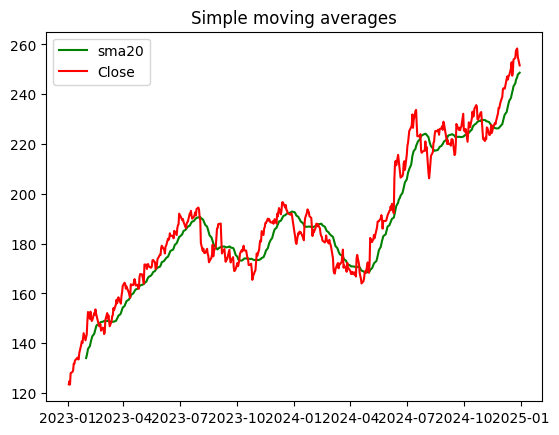

In [204]:
sma(data,20)

In [205]:
data['RSI_14'] = talib.RSI(data['Close']) #by default time period 
data['RSI_21'] = talib.RSI(data['Close'], timeperiod = 21)
print(data.tail())

Price            Close        High         Low        Open    Volume  \
Date                                                                   
2024-12-23  254.655716  255.034791  252.840088  254.156919  40858800   
2024-12-24  257.578674  257.588630  254.675658  254.875189  23234700   
2024-12-26  258.396667  259.474086  257.010028  257.568678  27237100   
2024-12-27  254.974930  258.077462  252.451019  257.209530  42355300   
2024-12-30  251.593094  252.889969  250.146586  251.623020  35557500   

Price       daily_return      sma 20     RSI_14     RSI_21  
Date                                                        
2024-12-23      0.306495  244.437349  73.085638  69.849128  
2024-12-24      1.147808  245.700803  75.750272  71.897166  
2024-12-26      0.317570  246.895920  76.452864  72.447114  
2024-12-27     -1.324219  247.926434  67.626263  66.712977  
2024-12-30     -1.326341  248.668144  60.225588  61.649254  


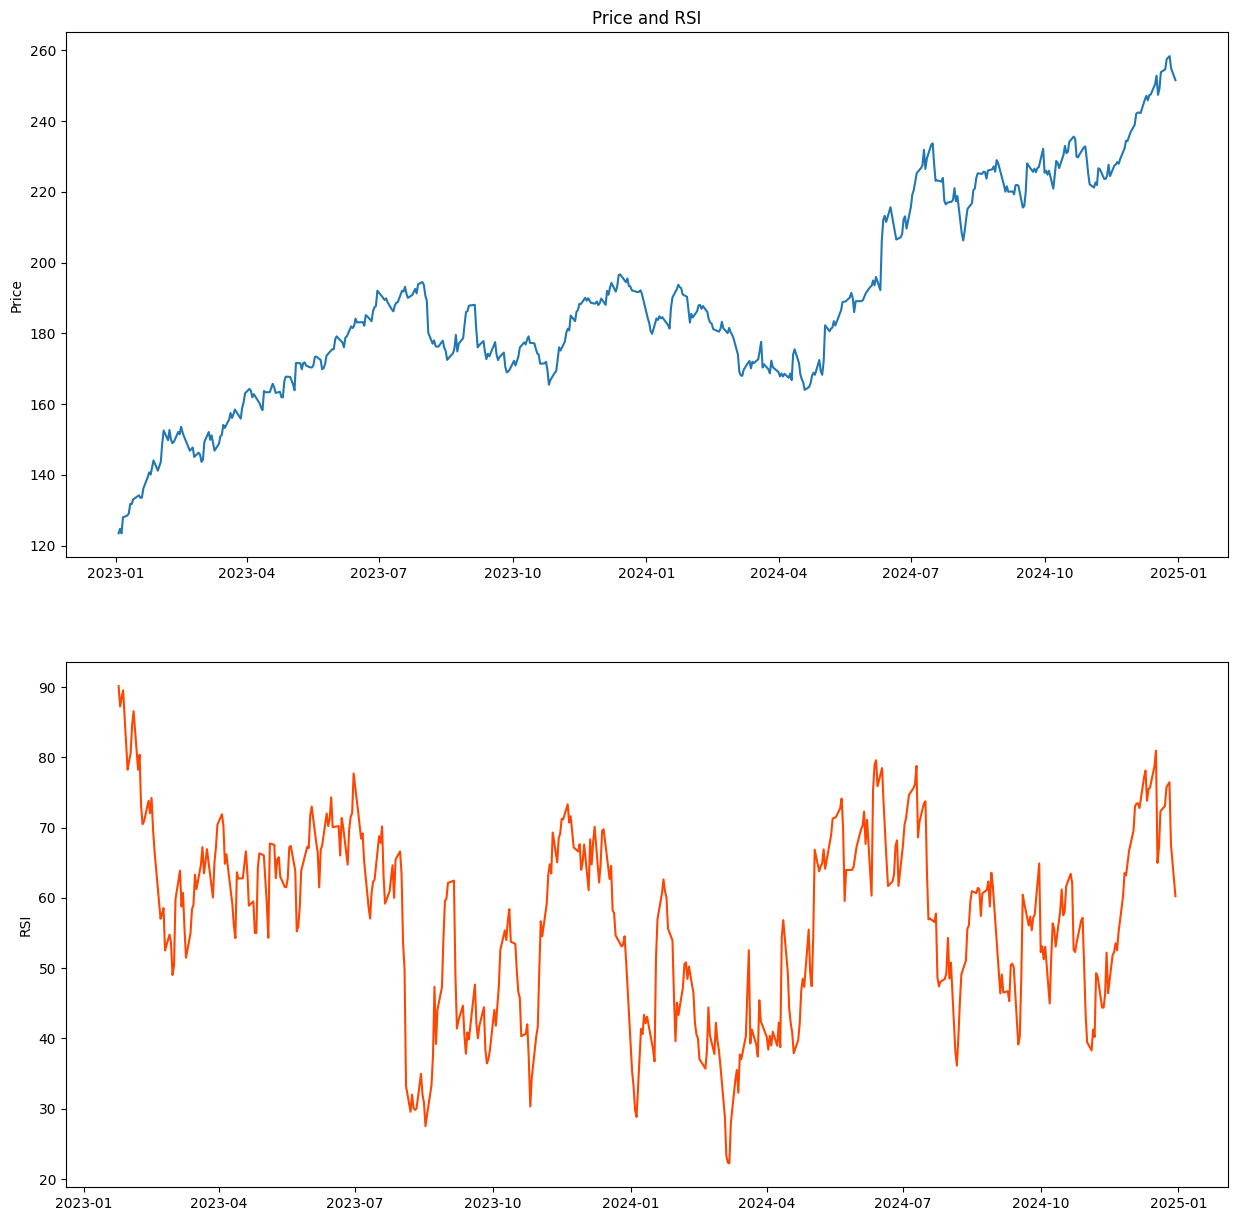

In [206]:
# Calculate RSI
data['RSI'] = talib.RSI(data['Close'])#important to frame 
fig, (ax1, ax2) = plt.subplots(2, figsize=(15,15))
ax1.set_ylabel('Price')
ax1.plot(data['Close'])
ax2.set_ylabel('RSI')
ax2.plot(data['RSI'], color='orangered')
ax1.set_title('Price and RSI')
plt.show()



## strategies

In [207]:
#data_clean = data.dropna()
data_clean = data.dropna(subset=['Close', 'RSI', 'sma 20'])  # si tu les utilises tous dans la stratégie
prices = data_clean[['Close']].copy()
prices.columns = ['AAPL']


In [208]:
stock_rsi = talib.RSI(data['Close']).to_frame()#important to frame 

In [209]:
signal = stock_rsi.copy()
signal[stock_rsi.isnull()] = 0

Text(0.5, 1.0, 'RSI')

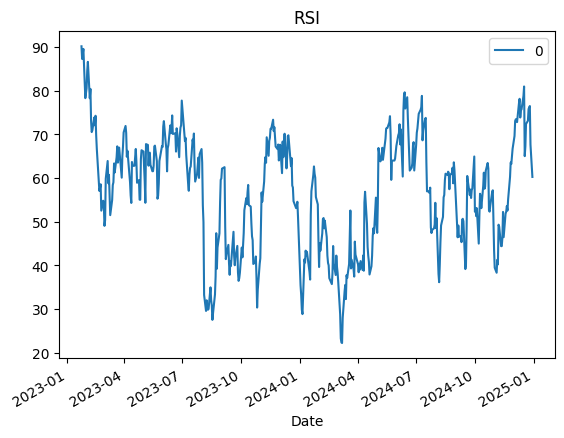

In [210]:
# Construct the signal
signal[stock_rsi > 30] = -1
signal[stock_rsi < 70] = 1
signal[(stock_rsi <= 70) & (stock_rsi >= 30)] = 0

# Plot the RSI
stock_rsi.plot()
plt.title('RSI')
#plt.savefig("rsi.jpg")

<Axes: xlabel='Date'>

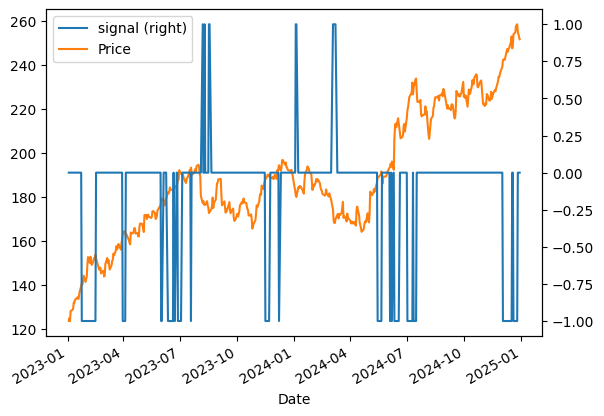

In [211]:
# Merge the data
combined_df = bt.merge(signal, data[['Close']])
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y =['signal'])
#plt.savefig("Data/rsisignal.jpg")

In [212]:
#testing RSI strat
signal.rename(columns = {0:'AAPL'}, inplace = True) #important de renommer 

In [213]:
bt_strategy = bt.Strategy('RSI_MeanReversion', 
                          [bt.algos.WeighTarget(signal),
                           bt.algos.Rebalance()])



100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


<Axes: title={'center': 'Equity Progression'}>

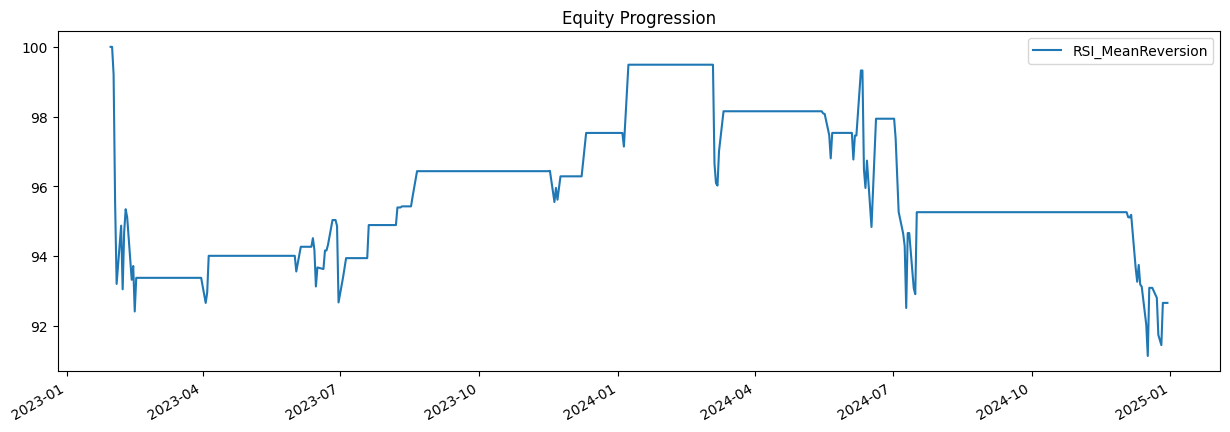

In [214]:
bt_backtest = bt.Backtest(bt_strategy, prices)
bt_result = bt.run(bt_backtest)
bt_result.plot()

In [221]:
bt_result.display()

Stat                 RSI_MeanReversion
-------------------  -------------------
Start                2023-01-30
End                  2024-12-30
Risk-free rate       0.00%

Total Return         -7.34%
Daily Sharpe         -0.43
Daily Sortino        -0.58
CAGR                 -3.90%
Max Drawdown         -8.86%
Calmar Ratio         -0.44

MTD                  -2.73%
3m                   -2.73%
6m                   -5.39%
YTD                  -5.00%
1Y                   -5.00%
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  -3.90%

Daily Sharpe         -0.43
Daily Sortino        -0.58
Daily Mean (ann.)    -3.64%
Daily Vol (ann.)     8.38%
Daily Skew           -1.13
Daily Kurt           15.47
Best Day             2.53%
Worst Day            -3.71%

Monthly Sharpe       -0.59
Monthly Sortino      -0.70
Monthly Mean (ann.)  -3.77%
Monthly Vol (ann.)   6.42%
Monthly Skew         -1.85
Monthly Kurt         5.47
Best Month           2.39%
Worst Month     

<Axes: xlabel='Date'>

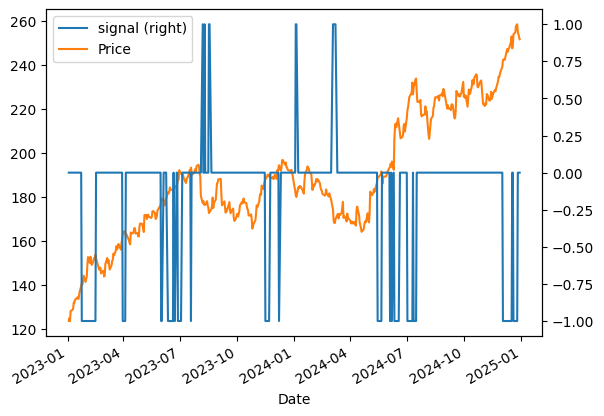

In [215]:
# Merge the data
combined_df = bt.merge(signal, data[['Close']])
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y =['signal'])
#plt.savefig("Data/rsisignal.jpg")

In [216]:
bt_strategy_rsi= bt.Strategy('RSI_Strategy', [
    bt.algos.RunWeekly(),
    bt.algos.SelectWhere(lambda x: x['RSI'] < 30),   # choisir seulement ceux qui sont "survendus"
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])


In [217]:
# Define the strategy 
bt_strategy = bt.Strategy('Trade_Weekly', 
[bt.algos.RunWeekly(), # Run weekly 
bt.algos.SelectAll(), # Use all data 
bt.algos.WeighEqually(), # Maintain equal weights 
bt.algos.Rebalance()]) # Rebalance


In [218]:
# Backtest
bt_test = bt.Backtest(bt_strategy, prices)
result = bt.run(bt_test)
result.display()

100%|██████████| 1/1 [00:00<00:00,  9.60it/s]

Stat                 Trade_Weekly
-------------------  --------------
Start                2023-01-30
End                  2024-12-30
Risk-free rate       0.00%

Total Return         76.62%
Daily Sharpe         1.50
Daily Sortino        2.68
CAGR                 34.56%
Max Drawdown         -16.61%
Calmar Ratio         2.08

MTD                  6.27%
3m                   8.36%
6m                   20.01%
YTD                  31.63%
1Y                   31.63%
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  34.56%

Daily Sharpe         1.50
Daily Sortino        2.68
Daily Mean (ann.)    32.01%
Daily Vol (ann.)     21.30%
Daily Skew           0.27
Daily Kurt           2.99
Best Day             7.26%
Worst Day            -4.82%

Monthly Sharpe       1.57
Monthly Sortino      3.97
Monthly Mean (ann.)  31.98%
Monthly Vol (ann.)   20.34%
Monthly Skew         0.07
Monthly Kurt         -0.61
Best Month           13.02%
Worst Month          -8.87%

Year

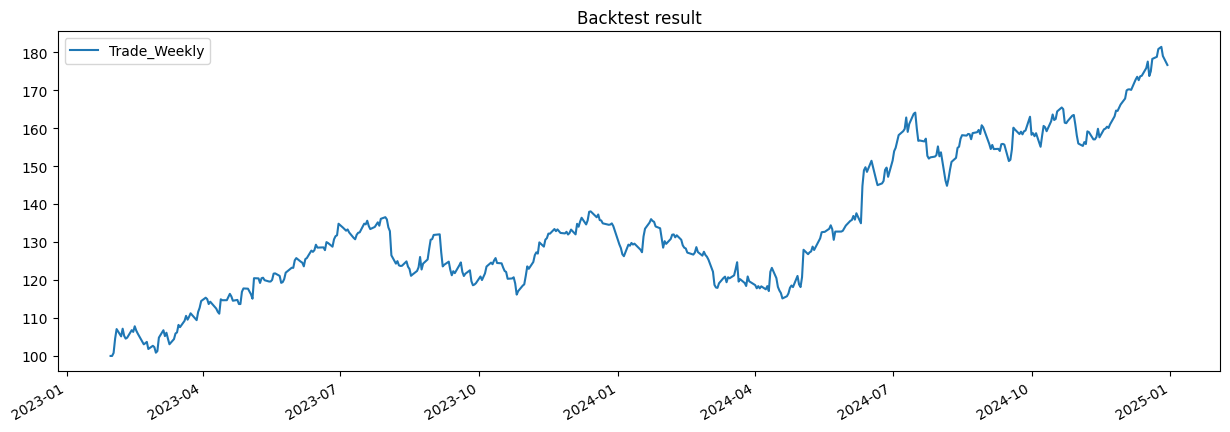

In [219]:
# Plot the test result
result.plot(title="Backtest result")
plt.show()

In [220]:
result.get_transactions()

,,price,quantity
Date,Security,,
2023-01-31,AAPL,142.444824,7020.0
